# Claims — Closed Summary, Open Aging Pareto & Open Tasks (v3.2 — Commented)
**Generated:** 2026-02-06 13:48:05

In [12]:
# Parameters
warehouses = ["OKC", "Atlanta", "Orlando", "Ontario", "El Paso", "Flowood", "Phoenix", "Charlotte"]
start_date = "01-01-2024"
end_date   = "12-31-2025"
max_labels = 25
INPUT_FILES = [
    (r"data\inputs\Ford Claims Planner.xlsx", "Ford Claims"), (r"data\inputs\Chrysler Claims Planner.xlsx", "Chrysler Claims")]
OUT_XLSX = "claims_analysis_output.xlsx"
FIG_DIR = "figs_claims"

In [13]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, PercentFormatter
from pathlib import Path
import re
from typing import Optional, Tuple, Dict
Path(FIG_DIR).mkdir(parents=True, exist_ok=True)

In [ ]:
# Helpers
def safe_filename(name: str, max_len: int = 180) -> str:
    if name is None:
        name = "untitled"
    name = re.sub(r'[<>:"/\\|?*]', "_", str(name))
    name = re.sub(r"[\x00-\x1f]", "_", name)
    name = re.sub(r"_+", "_", name).strip(" .")
    if not name:
        name = "unnamed"
    return name[:max_len]

def find_column(df: pd.DataFrame, candidates):
    cols = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in cols:
            return cols[cand.lower()]
    return None

def normalize_columns(df: pd.DataFrame):
    wh_col = find_column(df, ["Bucket Name", "Warehouse", "WH", "Facility"])
    sd_col = find_column(df, ["Start Date", "Open Date", "Opened Date", "Created Date", "Create Date", "Claim Open Date", "Date Opened"])
    cd_col = find_column(df, ["Completed Date", "Close Date", "Closed Date"])
    task_col = find_column(df, ["Task Name", "Task"])
    labels_col = find_column(df, ["Labels", "Label"])
    
    due_col = find_column(df, ["Due Date", "Due date", "Task Due", "Due"])

    if wh_col is None:
        raise KeyError("Warehouse column not found")
    if sd_col is None:
        raise KeyError("Start/Open date column not found")

    out = df.copy()
    out.rename(columns={wh_col: "Warehouse", sd_col: "Start Date"}, inplace=True)
    if cd_col is not None: out.rename(columns={cd_col: "Completed Date"}, inplace=True)
    else: out["Completed Date"] = pd.NaT
    if task_col is not None: out.rename(columns={task_col: "Task Name"}, inplace=True)
    else: out["Task Name"] = ""
    if labels_col is not None: out.rename(columns={labels_col: "Labels"}, inplace=True)
    else: out["Labels"] = ""
    if due_col is not None: out.rename(columns={due_col: "Due Date"}, inplace=True)
    else: out["Due Date"] = pd.NaT

    out["Start Date"] = pd.to_datetime(out["Start Date"], errors="coerce")
    out["Completed Date"] = pd.to_datetime(out["Completed Date"], errors="coerce")
    out["Due Date"] = pd.to_datetime(out["Due Date"], errors="coerce")
    out["Warehouse"] = out["Warehouse"].astype(str).str.strip()
    out["Task Name"] = out["Task Name"].astype(str).str.strip()
    out["Labels"] = out["Labels"].astype(str)
    return out, {}

In [16]:
def filter_by_warehouses_and_dates(df, warehouses, start_date, end_date):
    wanted = {w.strip().lower(): w for w in warehouses}
    df2 = df[df["Warehouse"].str.lower().isin(wanted.keys())].copy()
    df2["Warehouse"] = df2["Warehouse"].str.lower().map(wanted)
    if start_date:
        df2 = df2[df2["Start Date"] >= pd.to_datetime(start_date)]
    if end_date:
        df2 = df2[df2["Start Date"] <= pd.to_datetime(end_date)]
    return df2

def closed_claims_summary(df, dataset_name):
    closed = df[df["Completed Date"].notna()].copy()
    closed["DaysToClose"] = (closed["Completed Date"] - closed["Start Date"]).dt.days
    agg = closed.groupby("Warehouse", dropna=False)["DaysToClose"].agg(
        CountClosed="count",
        MeanDaysToClose=lambda s: float(np.nanmean(s)) if len(s) else np.nan,
        MedianDaysToClose=lambda s: float(np.nanmedian(s)) if len(s) else np.nan,
        MinDaysToClose=lambda s: float(np.nanmin(s)) if len(s) else np.nan,
        MaxDaysToClose=lambda s: float(np.nanmax(s)) if len(s) else np.nan,
    ).reset_index()
    agg.insert(0, "Dataset", dataset_name)
    return agg

def open_claims_aging_table(df, dataset_name):
    open_df = df[df["Completed Date"].isna()].copy()
    today = pd.Timestamp.today().normalize()
    open_df["AgeDays"] = (today - open_df["Start Date"].dt.normalize()).dt.days
    bucket_labels = ["<30 days", "30-<60 days", "60-<90 days", ">= 90 days"]
    bins = [-1, 29, 59, 89, float("inf")]
    open_df["Aging Bucket"] = pd.cut(open_df["AgeDays"], bins=bins, labels=bucket_labels, include_lowest=True, right=True)
    counts = (open_df.groupby(["Warehouse", "Aging Bucket"]).size().rename("Count").reset_index())
    all_wh = [w for w in warehouses if w in counts["Warehouse"].unique().tolist()]
    full_index = pd.MultiIndex.from_product([all_wh, bucket_labels], names=["Warehouse", "Aging Bucket"])
    counts = counts.set_index(["Warehouse", "Aging Bucket"]).reindex(full_index, fill_value=0).reset_index()
    counts["Percent"] = counts.groupby("Warehouse")["Count"].transform(lambda x: (x / x.sum() * 100.0) if x.sum() else 0.0)
    counts["CumPercent"] = counts.groupby("Warehouse")["Percent"].cumsum()
    counts.insert(0, "Dataset", dataset_name)
    return counts

def plot_pareto_for_wh(df_aging_wh, dataset_name, wh, max_labels=25, save_dir=FIG_DIR):
    labels = df_aging_wh["Aging Bucket"].astype(str).tolist()
    x = np.arange(len(labels))
    counts = df_aging_wh["Count"].to_numpy(dtype=float)
    cum_pct = df_aging_wh["CumPercent"].to_numpy(dtype=float)
    fig, ax = plt.subplots(figsize=(8, 4.6))
    bars = ax.bar(x, counts)
    ax.set_xticks(x); ax.set_xticklabels(labels, rotation=0)
    ax.set_xlabel("Claim Age"); ax.set_ylabel("Open Claims (count)")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax.twinx(); ax2.plot(x, cum_pct, marker="o"); ax2.set_ylabel("Cumulative %")
    ax2.set_ylim(0, 100); ax2.yaxis.set_major_formatter(PercentFormatter(xmax=100))
    total = int(np.nansum(counts))
    ax.set_title(f"{dataset_name} — Open Claims Aging — {wh} (n={total})")
    ax.grid(axis="y", linestyle="--", alpha=0.3); fig.tight_layout()
    if len(labels) <= max_labels:
        for rect, val in zip(bars, counts):
            ax.text(rect.get_x()+rect.get_width()/2, rect.get_height(), f"{int(val)}", ha="center", va="bottom", fontsize=9)
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    fname = f"{safe_filename(dataset_name)}__aging_pareto__{safe_filename(wh)}.png"
    fig.savefig(Path(save_dir)/fname, dpi=150, bbox_inches="tight"); plt.show()

def extract_wh_actions(labels_value: str):
    parts = re.split(r"[;|,]", str(labels_value))
    wh_only = []
    for p in parts:
        s = p.strip()
        if re.match(r"(?i)^WH\b", s):
            wh_only.append(s)
    return wh_only

In [17]:
# Load/standardize/combine/compute
combined_rows = []
closed_summaries = []
open_aging_tables = []

for rel_path, dname in INPUT_FILES:
    path = Path(rel_path)
    if not path.exists():
        print(f"WARNING: File not found, skipping: {rel_path}")
        continue
    raw = pd.read_excel(path)
    df_std, _ = normalize_columns(raw)
    df_comb = raw.copy()
    for col in ["Warehouse", "Start Date", "Completed Date", "Task Name", "Labels", "Due Date"]:
        if col in df_std.columns:
            df_comb[col] = df_std[col]
    df_comb["Dataset"] = dname
    combined_rows.append(df_comb)
    df_std_f = filter_by_warehouses_and_dates(df_std, warehouses, start_date, end_date)
    closed_summaries.append(closed_claims_summary(df_std_f, dname))
    open_aging_tables.append(open_claims_aging_table(df_std_f, dname))

combined_all = pd.concat(combined_rows, ignore_index=True) if combined_rows else pd.DataFrame()
if not combined_all.empty:
    mask = combined_all["Warehouse"].notna()
    if start_date:
        mask &= pd.to_datetime(combined_all["Start Date"], errors="coerce") >= pd.to_datetime(start_date)
    if end_date:
        mask &= pd.to_datetime(combined_all["Start Date"], errors="coerce") <= pd.to_datetime(end_date)
    wanted = {w.strip().lower() for w in warehouses}
    mask &= combined_all["Warehouse"].astype(str).str.lower().isin(wanted)
    combined_all_filtered = combined_all[mask].copy()
else:
    combined_all_filtered = combined_all

closed_all = pd.concat(closed_summaries, ignore_index=True) if closed_summaries else pd.DataFrame()
aging_all  = pd.concat(open_aging_tables, ignore_index=True) if open_aging_tables else pd.DataFrame()
combined_all_filtered.head(10), closed_all.head(5), aging_all.head(5)

C:\Users\dbalan\AppData\Local\Temp\ipykernel_28112\4085303659.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = (open_df.groupby(["Warehouse", "Aging Bucket"]).size().rename("Count").reset_index())
C:\Users\dbalan\AppData\Local\Temp\ipykernel_28112\4085303659.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = (open_df.groupby(["Warehouse", "Aging Bucket"]).size().rename("Count").reset_index())


(                         Task ID  \
 65  I_tZinZ1bE-oYKQNh-fyK2UAPPTz   
 70  8YLvb5Wq5kG5hWLSAdk8PmUAPWKq   
 71  2pW0a0KbhkeKowYp7a9u5GUAGUzb   
 75  R1ff0VQpzUyj_0ik3pXor2UAJFjq   
 76  aRpoR0F7Z0iQaiZujgpBnWUAKM6N   
 77  yJFWSNnH506e37VY5F389mUAJ9ra   
 80  Y82z6wTANketkeUTTc7eAWUAPZm5   
 81  9q9YXcDQLEmlgGUCqbqPcWUAIfeY   
 82  agv8k0_4RUe0f245dgHRBWUAM82y   
 88  pZuToVox1EuX1VbefcAnAGUAEcm4   
 
                                             Task Name Bucket Name  \
 65  ATLANTA - FORD SHORTAGE- PO# 74532 - INV H3626...     Atlanta   
 70  HL3Z6006DARM - 03211 - DON FRANKLIN FORD LINCO...     Atlanta   
 71  ORLANDO - LC3Z6006B - PO 172332 - 03096 - JARR...     Orlando   
 75  HL3Z6006DARM - 00960 - LAFAYETTE FORD - S39-01...   Charlotte   
 76  GC4Z6007FARM - PO 170785 - 08972 - LHM FORD MF...     Phoenix   
 77  ORLANDO - FORD SHORTAGE- PO# 173655 - INV G872...     Orlando   
 80  5C3Z9A543ARM - PO 173665 - 04809 - BARTOW FORD...     Orlando   
 81  GK4Z6006CRM - PO 171786 - 

In [18]:
# Open Tasks – detail & aggregate
open_task_rows = []
for rel_path, dname in INPUT_FILES:
    path = Path(rel_path)
    if not path.exists():
        continue
    raw = pd.read_excel(path)
    df_std, _ = normalize_columns(raw)
    df_std_f = filter_by_warehouses_and_dates(df_std, warehouses, start_date, end_date)
    open_df = df_std_f[df_std_f["Completed Date"].isna()].copy()
    open_df["ActionList"] = open_df["Labels"].apply(extract_wh_actions)
    open_df = open_df[open_df["ActionList"].map(len) > 0].copy().explode("ActionList")
    open_df.rename(columns={"ActionList":"Action Required"}, inplace=True)
    open_df["Dataset"] = dname
    open_task_rows.append(open_df[["Dataset","Warehouse","Task Name","Action Required","Due Date"]])

open_tasks_detail = pd.concat(open_task_rows, ignore_index=True) if open_task_rows else pd.DataFrame(columns=["Dataset","Warehouse","Task Name","Action Required","Due Date"])
if not open_tasks_detail.empty:
    open_tasks_detail = open_tasks_detail.sort_values(["Action Required","Due Date","Warehouse"], na_position="last").reset_index(drop=True)

if not open_tasks_detail.empty:
    open_tasks_agg = (open_tasks_detail.groupby(["Dataset","Warehouse","Action Required"], dropna=False).size().rename("Count").reset_index()
                      .sort_values(["Warehouse","Count"], ascending=[True, False], ignore_index=True))
else:
    open_tasks_agg = pd.DataFrame(columns=["Dataset","Warehouse","Action Required","Count"])

open_tasks_detail.head(10), open_tasks_agg.head(10)

(           Dataset  Warehouse  \
 0      Ford Claims    Orlando   
 1      Ford Claims    Ontario   
 2      Ford Claims    Phoenix   
 3  Chrysler Claims  Charlotte   
 4  Chrysler Claims    Flowood   
 5  Chrysler Claims  Charlotte   
 6  Chrysler Claims    Ontario   
 7      Ford Claims    Atlanta   
 8      Ford Claims    Atlanta   
 9      Ford Claims    Atlanta   
 
                                            Task Name     Action Required  \
 0  HC4Z7000C - 02159 - PALMETTO FORD OF MIAMI - S...  WH P/U from Dealer   
 1  9C2Z6006BARM - 05389 - KEARNY PEARSON FORD - S...  WH P/U from Dealer   
 2  6C3Z6049DRM - 05730 - COURTESY FORD OF GLOBE -...  WH P/U from Dealer   
 3  CHRYSLER DAMAGE - R8447797AA - Inv 3721415 - H...  WH P/U from dealer   
 4  CHRYSLER DAMAGE - PART# R8090720AI- Inv 353158...  WH P/U from dealer   
 5  CHRYSLER DAMAGE - PART# R8348504AA - Inv 33755...  WH P/U from dealer   
 6  CHRYSLER DAMAGE - PART# 68411234AA - Inv 34100...  WH P/U from dealer   
 7  YC3Z

In [19]:
# Export all outputs to Excel (overwrites file each run to avoid stale data)
with pd.ExcelWriter(OUT_XLSX, engine="openpyxl") as writer:
    if not combined_all_filtered.empty:
        combined_all_filtered.to_excel(writer, sheet_name="All_Claims_Combined", index=False)
    if not closed_all.empty:
        closed_all.to_excel(writer, sheet_name="Closed_Claims_Summary", index=False)
    if not aging_all.empty:
        aging_all.to_excel(writer, sheet_name="Open_Claims_Aging", index=False)

    # Leadership-friendly rollup: Ford vs Chrysler open-claims aging by warehouse
    if not aging_all.empty:
        bucket_order = ["<30 days", "30-<60 days", "60-<90 days", ">= 90 days"]
        _keep = set(["Ford Claims", "Chrysler Claims"])
        aging_fc = aging_all[aging_all["Dataset"].isin(_keep)].copy()
        aging_summary = (
            aging_fc
            .pivot_table(
                index=["Dataset", "Warehouse"],
                columns="Aging Bucket",
                values="Count",
                aggfunc="sum",
                fill_value=0
            )
            .reindex(columns=bucket_order, fill_value=0)
            .reset_index()
        )
        aging_summary["Total Open Claims"] = aging_summary[bucket_order].sum(axis=1)
        aging_summary["% >= 90 days"] = np.where(
            aging_summary["Total Open Claims"] > 0,
            aging_summary[">= 90 days"] / aging_summary["Total Open Claims"],
            np.nan
        )
        aging_summary.to_excel(writer, sheet_name="Open_Aging_Summary", index=False)
    if not open_tasks_detail.empty:
        open_tasks_detail.to_excel(writer, sheet_name="Open_Tasks_By_Warehouse", index=False)
    if not open_tasks_agg.empty:
        open_tasks_agg.to_excel(writer, sheet_name="Open_Tasks_Aggregate", index=False)

    if 'wh_respond_table' in globals() and wh_respond_table is not None and not wh_respond_table.empty:
        wh_respond_table.to_excel(writer, sheet_name="WH_Please_Respond", index=False)
print(f"Wrote: {OUT_XLSX}")

Wrote: claims_analysis_output.xlsx


In [20]:
# --- Summary table: Open claims aging by warehouse (Ford vs Chrysler) ---
# This rolls up the open-claims aging buckets into a single, leadership-friendly table
# BEFORE generating the Pareto charts below.

if aging_all.empty:
    print("No open-claims aging data to summarize (aging_all is empty).")
else:
    bucket_order = ["<30 days", "30-<60 days", "60-<90 days", ">= 90 days"]
    # Keep only the two datasets you care about (aligned with INPUT_FILES labels)
    _keep = set(["Ford Claims", "Chrysler Claims"])
    aging_fc = aging_all[aging_all["Dataset"].isin(_keep)].copy()

    aging_summary = (
        aging_fc
        .pivot_table(
            index=["Dataset", "Warehouse"],
            columns="Aging Bucket",
            values="Count",
            aggfunc="sum",
            fill_value=0
        )
        .reindex(columns=bucket_order, fill_value=0)
        .reset_index()
    )
    aging_summary["Total Open Claims"] = aging_summary[bucket_order].sum(axis=1)
    aging_summary["% >= 90 days"] = np.where(
        aging_summary["Total Open Claims"] > 0,
        aging_summary[">= 90 days"] / aging_summary["Total Open Claims"],
        np.nan
    )

    display(
        aging_summary
        .sort_values(["Dataset", "Total Open Claims"], ascending=[True, False])
        .reset_index(drop=True)
    )


Aging Bucket,Dataset,Warehouse,<30 days,30-<60 days,60-<90 days,>= 90 days,Total Open Claims,% >= 90 days
0,Chrysler Claims,Charlotte,0,2,1,25,28,0.892857
1,Chrysler Claims,Ontario,0,3,3,18,24,0.750000
2,Chrysler Claims,Phoenix,0,2,2,18,22,0.818182
3,Chrysler Claims,Orlando,0,6,0,13,19,0.684211
4,Chrysler Claims,Flowood,0,2,2,14,18,0.777778
5,Chrysler Claims,Atlanta,0,1,0,10,11,0.909091
6,Chrysler Claims,OKC,0,0,0,8,8,1.000000
7,Chrysler Claims,El Paso,0,0,1,4,5,0.800000
8,Ford Claims,Atlanta,0,1,3,2,6,0.333333
9,Ford Claims,Orlando,0,0,4,1,5,0.200000


In [21]:
# --- Warehouse action required: tag scan for 'WH Please Resond/Respond' ---
# Uses the *raw combined* dataset (combined_all) so action items are not lost to aging/pareto filters.
# Outputs a table: Warehouse (Bucket Name), Task ID, Task Name.

# Tag text in the source data is sometimes misspelled as 'Resond'. We match both spellings.
TAG_PATTERN = r"\bwh\s*please\s*respo?nd\b"

if combined_all is None or combined_all.empty:
    wh_respond_table = pd.DataFrame(columns=["Warehouse (Bucket Name)", "Task ID", "Task Name"])
    print("No combined data available to evaluate warehouse-response tags.")
else:
    # Identify columns robustly
    task_id_col = find_column(combined_all, ["Task ID", "Task Id", "TaskID", "ID", "Id"])
    task_name_col = find_column(combined_all, ["Task Name", "Task", "Title"]) or "Task Name"
    warehouse_col = find_column(combined_all, ["Warehouse", "Bucket Name", "Bucket", "WH"]) or "Warehouse"
    labels_col = find_column(combined_all, ["Labels", "Label", "Tags", "Tag"]) or "Labels"

    # Normalize labels and scan for the tag (case-insensitive)
    labels_series = combined_all[labels_col].fillna("").astype(str)
    wh_mask = labels_series.str.lower().str.contains(TAG_PATTERN, regex=True)

    # Build output table
    keep_cols = [warehouse_col, task_name_col]
    if task_id_col:
        keep_cols.insert(1, task_id_col)
    else:
        # Create a placeholder if no Task ID column exists
        combined_all["Task ID"] = ""
        task_id_col = "Task ID"
        keep_cols.insert(1, task_id_col)

    wh_respond_table = (
        combined_all.loc[wh_mask, keep_cols]
        .rename(columns={
            warehouse_col: "Warehouse (Bucket Name)",
            task_id_col: "Task ID",
            task_name_col: "Task Name",
        })
        .dropna(subset=["Warehouse (Bucket Name)"])
        .sort_values(["Warehouse (Bucket Name)", "Task ID"], kind="mergesort")
        .drop_duplicates(subset=["Task ID"], keep="first")
        .reset_index(drop=True)
    )

    if wh_respond_table.empty:
        print("No items found with warehouse-response tag (WH Please Resond/Respond).")
    else:
        display(wh_respond_table)

        # Quick rollup by warehouse
        wh_counts = (
            wh_respond_table.groupby("Warehouse (Bucket Name)", as_index=False)
            .size()
            .rename(columns={"size": "Tagged Items"})
            .sort_values("Tagged Items", ascending=False)
        )
        display(wh_counts)


,Warehouse (Bucket Name),Task ID,Task Name
0,Atlanta,2PN76cTwrUCYbHCrnNlzdWUANcY3,FL3Z7902FRM - 05783 -PO 170428 SHARP MOTOR CO ...
1,Atlanta,9l_NTmkqmUyer6yfbgbog2UAF53_,YC3Z7L596AA - 00402 - PO 170621 - AKINS FORD C...
2,Atlanta,DANHJND9CEOEX9MokamBDmUAJafX,LC3Z7000QRM - 00845 - STIVERS FORD SOUTH - S39...
3,Atlanta,F9FBrcnLzUuACHCiAb3rsWUAJ5lk,CHRYSLER MIS-SHIP - SHORT 68465585AC - PO 1318...
4,Atlanta,FFwFCTxGcUSFlq62I04z-GUAAcql,PO 160295- INV S53513 - JL3Z7000F- QTY 1 -7.1.24
5,Atlanta,JQzX2NGQ00-wn1BaYmR5UWUAAFJq,CHRYSLER OVERSHIPMENT - PO# 1306422 - PART# 68...
6,Atlanta,Z8p-hjf9oUqd8TQpk2SDjmUAMX95,PO# 158427 - Q89654 - HL3Z6006D - 1 - 4.22.24 ...
7,Atlanta,a_CxZwy-n0WX_ksTlIBFDWUAFMdT,CHRYSLER PICKING ERROR - PO# 1305309 - PART# 6...
8,Atlanta,iiXW_h4e5ESjrYZQR5eiRWUAK5G6,ATLANTA - CHRYSLER SHORTAGE - PO 0835616- 6804...
9,Atlanta,sPJVvzzjdUGlx7aMw_6Ma2UAGBcG,PO# 159493 - R62299 - MULTI - 3 - 5.22.24


,Warehouse (Bucket Name),Tagged Items
5,Ontario,14
0,Atlanta,13
6,Orlando,10
7,Phoenix,9
3,Flowood,1
2,El Paso,1
1,Charlotte,1
4,OKC,1


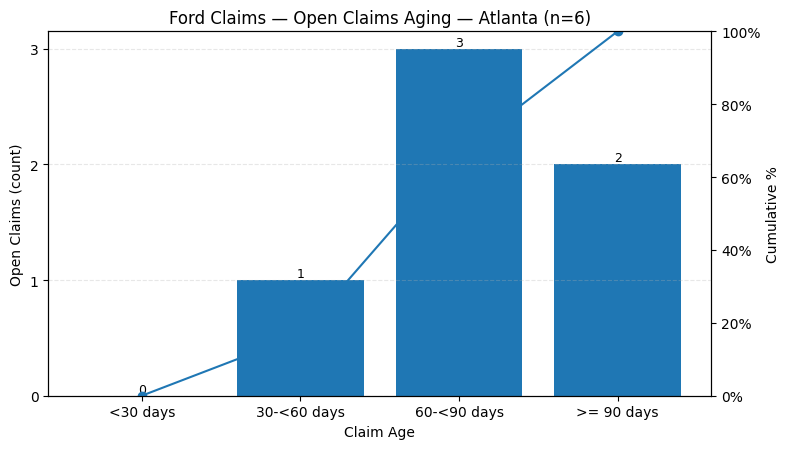

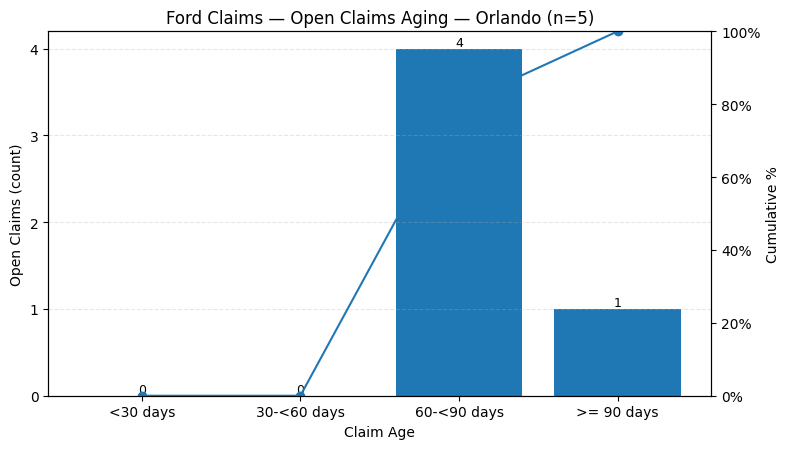

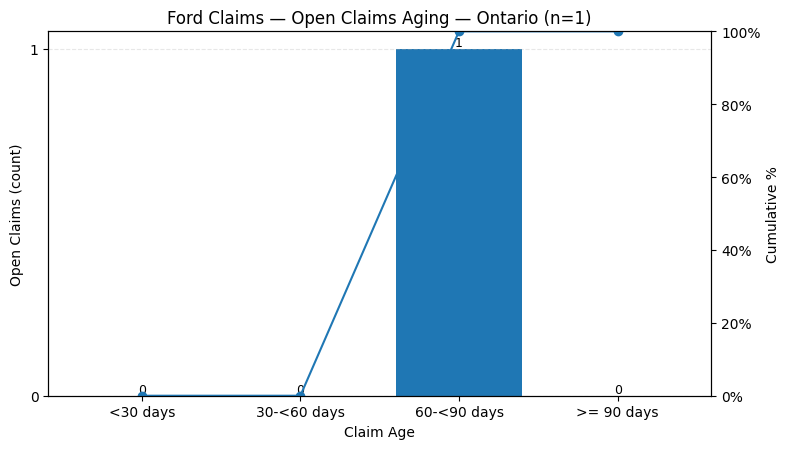

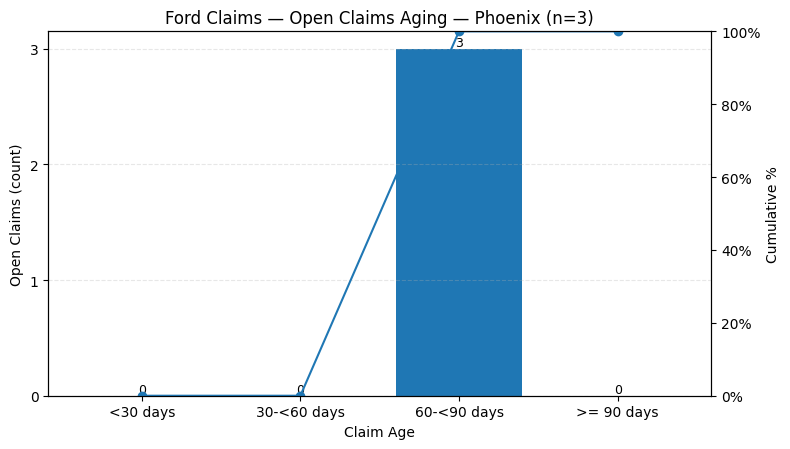

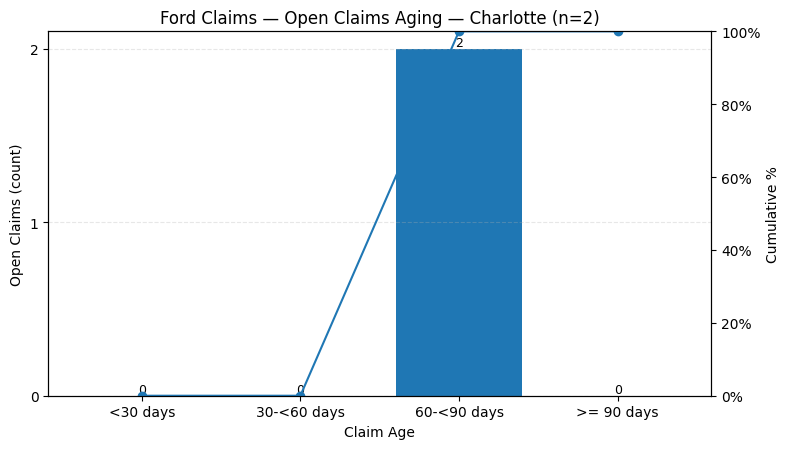

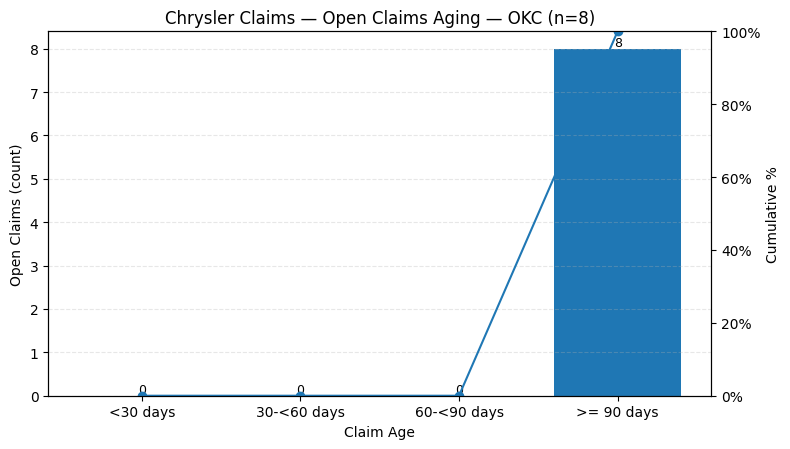

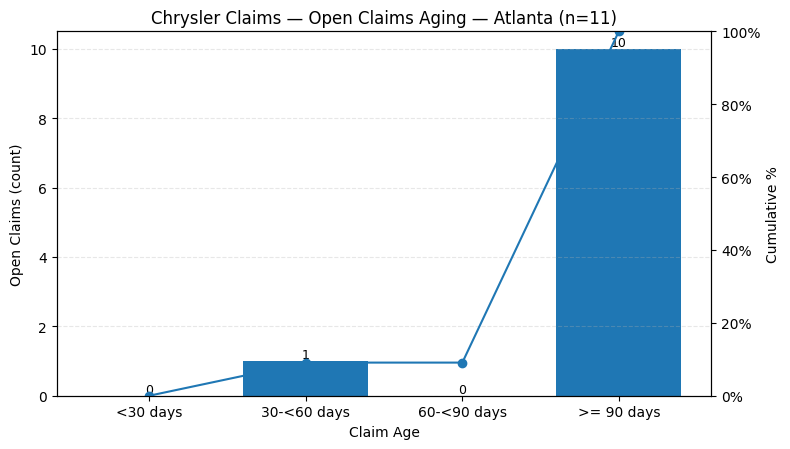

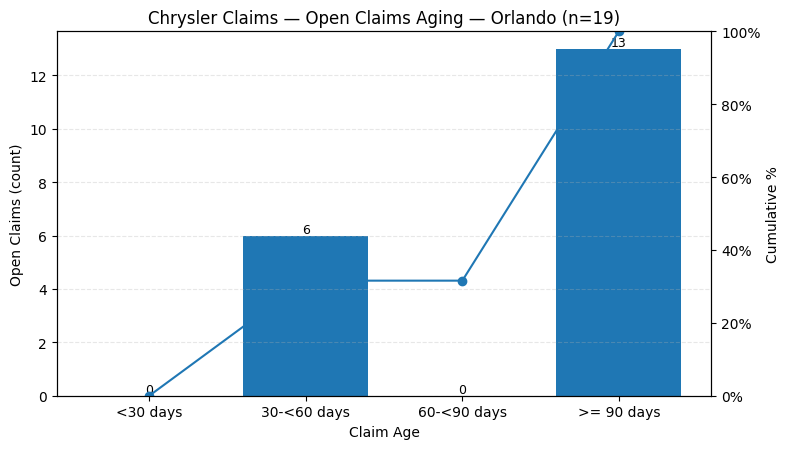

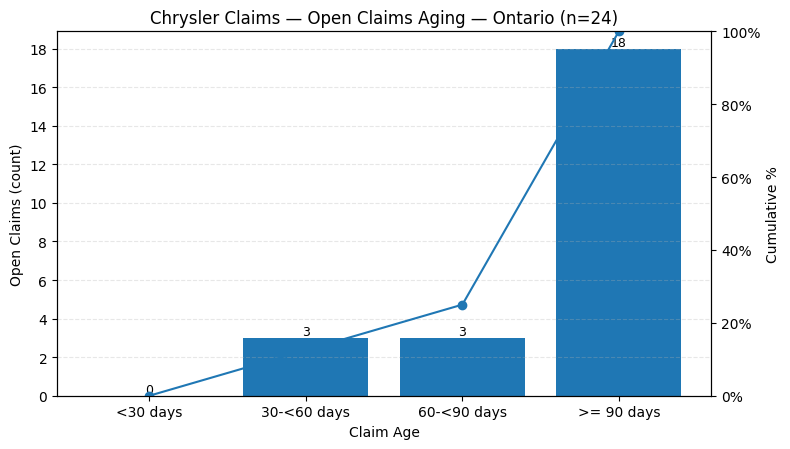

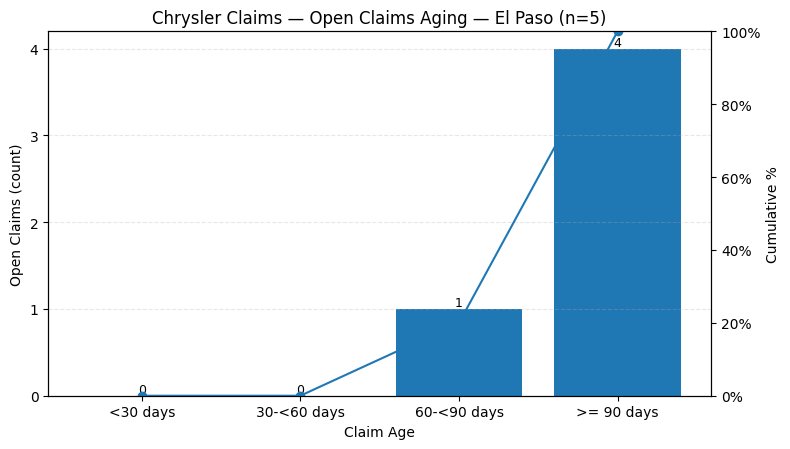

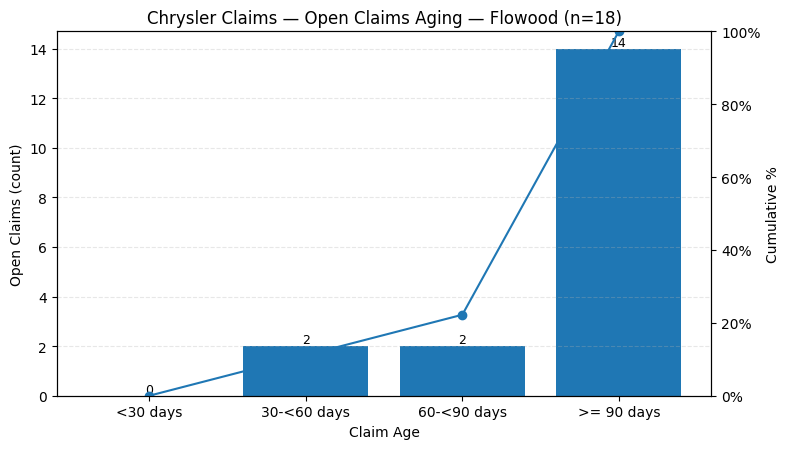

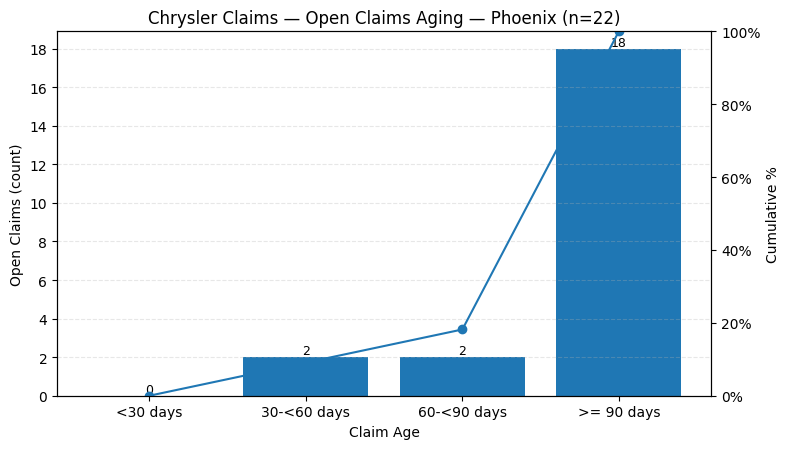

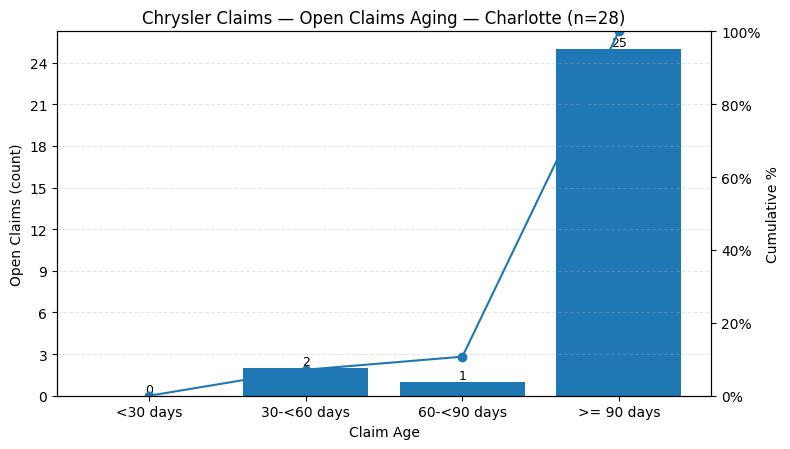

In [22]:
# Pareto chart generation
if not aging_all.empty:
    desired_order = ["<30 days", "30-<60 days", "60-<90 days", ">= 90 days"]
    for dname in aging_all["Dataset"].unique():
        sub = aging_all[aging_all["Dataset"] == dname]
        for wh in warehouses:
            wh_rows = sub[sub["Warehouse"] == wh]
            if wh_rows.empty:
                continue
            wh_rows = wh_rows.set_index("Aging Bucket").reindex(desired_order).reset_index()
            plot_pareto_for_wh(wh_rows, dname, wh, max_labels=max_labels, save_dir=FIG_DIR)
else:
    print("No aging data to plot.")